Importing modules

In [1]:
#suppressing a warning - UserWarning: Wswiglal-redir-stdio
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
import lal as _lal

In [ ]:
import sys

sys.path.insert(0, "../")
from src.regular_precession import *
from src.systems_lib import *
from src.mismatch_n_SNR import *
import matplotlib.pyplot as plt
import matplotlib
import math
matplotlib.rcParams["figure.dpi"] = 200


Defining default system at z = 0.3

In [3]:
# Define the default parameters for the system 2 -- default edge-on system
default_precession_params_sys2 = redshifted_new_params(0.3, default_precession_params_sys2)
default_precession_params_sys2_NP = redshifted_new_params(0.3, default_precession_params_sys2_NP)

In [4]:
# We will now change the phi_J and cos_theta_J values for edge-on systems with theta_S = np.pi/4 and phi_S = 0
phi_J_array = np.linspace(0, 2*np.pi, 201)

theta_J_array = np.arctan2(1, -np.cos(phi_J_array))

# We will now calculate the SNR and mismatch for these systems

# This is for 50th percentile in both precession amplitude and frequency

default_precession_params_sys2['theta_tilde'] = 4
default_precession_params_sys2['omega_tilde'] = 2

mismatches_EO_arr_42 = []
SNRs_EO_arr_42 = []
SNRs_EO_arr_42_NP = []

for phi_J, theta_J in zip(phi_J_array, theta_J_array):
    default_precession_params_sys2['phi_J'] = phi_J
    default_precession_params_sys2['theta_J'] = theta_J
    default_precession_params_sys2_NP['phi_J'] = phi_J
    default_precession_params_sys2_NP['theta_J'] = theta_J

    # Calculate the SNR and mismatch
    min_mismatch, _, min_gammaP, _ = opt_mismatch_extremas_gammaP(default_precession_params_sys2, default_precession_params_sys2_NP, size_of_gammaP_arr=51, return_tc_phic=False)

    # Calculate the SNR
    default_precession_params_sys2['gammaP'] = min_gammaP
    All_SNRs = get_SNRs(default_precession_params_sys2, default_precession_params_sys2_NP)
    
    SNR_RPRP = All_SNRs['SNR_RPRP']
    
    SNR_NPNP = All_SNRs['SNR_NPNP']
    
    mismatches_EO_arr_42.append(min_mismatch)
    SNRs_EO_arr_42.append(SNR_RPRP)
    SNRs_EO_arr_42_NP.append(SNR_NPNP)

# This code takes about 3 minutes to run on a single core on MacBook Pro M1 2020

/Users/tamanjyotsingh/Documents/GitHub/regular_precession/notebooks/../regular_precession.py:225: RuntimeWarning: divide by zero encountered in divide
  tan_psi = num_psi / den_psi
/Users/tamanjyotsingh/Documents/GitHub/regular_precession/notebooks/../regular_precession.py:225: RuntimeWarning: divide by zero encountered in divide
  tan_psi = num_psi / den_psi


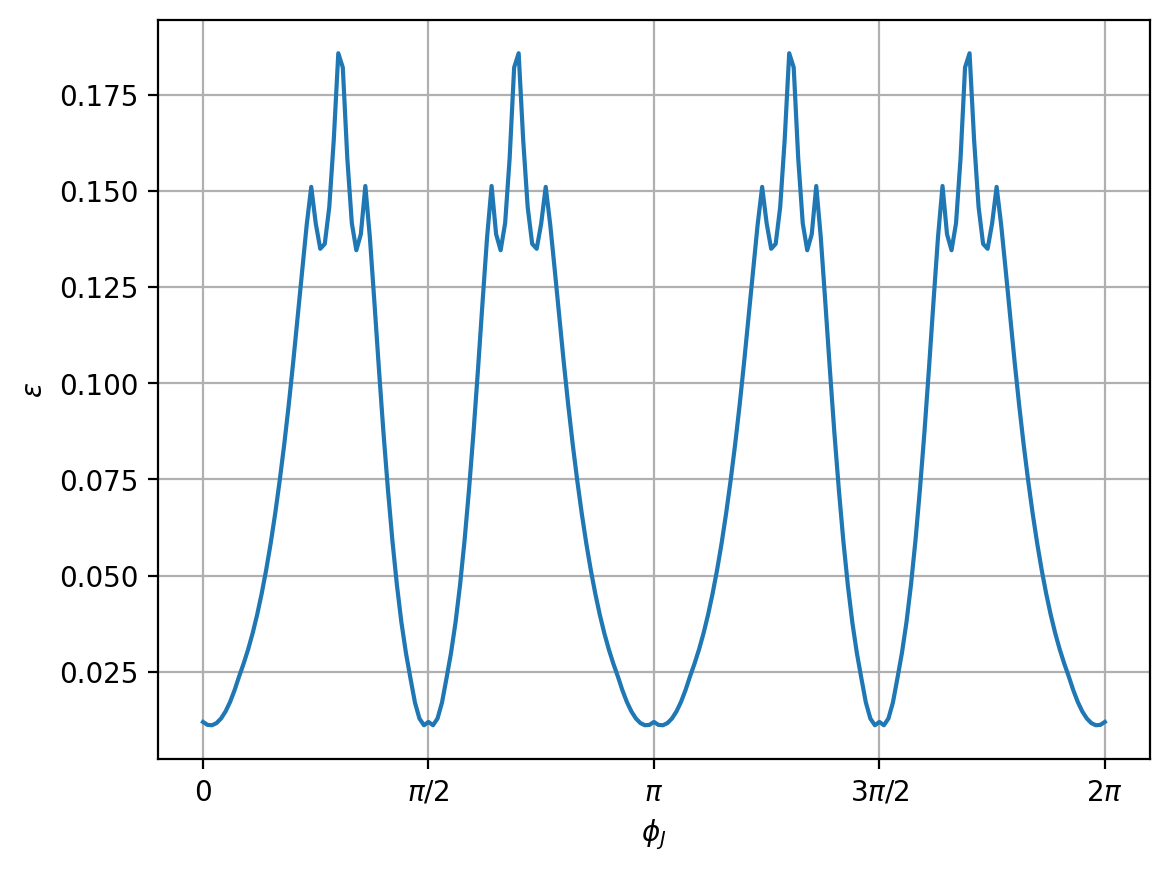

In [5]:
# Plotting just the mismatches
plt.plot(phi_J_array, mismatches_EO_arr_42, label='Mismatch')
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
plt.xlabel(r'$\phi_J$')
plt.ylabel(r'$\epsilon$')
plt.grid()

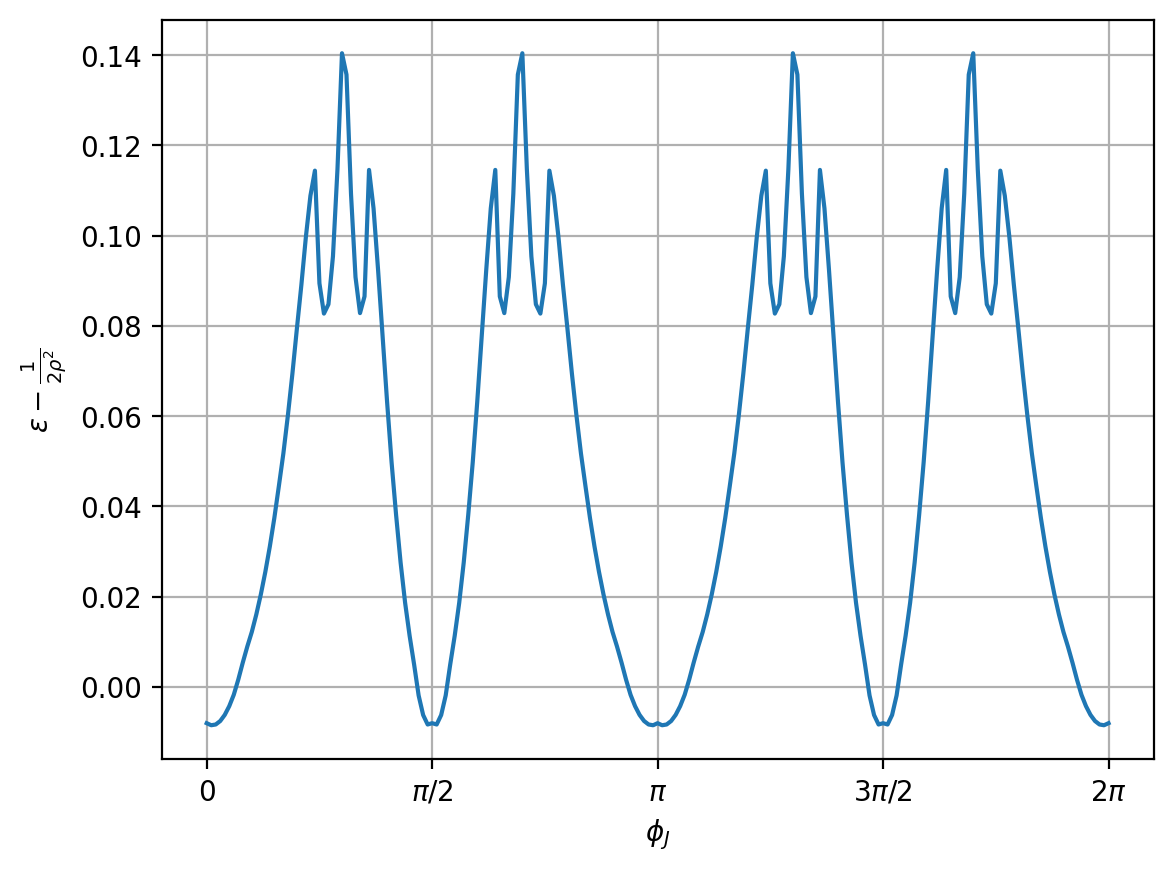

In [6]:
# Plotting the lindblom inequality:
plt.plot(phi_J_array, np.array(mismatches_EO_arr_42)-(0.5*(np.array(SNRs_EO_arr_42)**(-2))), label='Mismatch-SNR')
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']);
plt.xlabel(r'$\phi_J$')
plt.ylabel(r'$\epsilon - \frac{1}{2\rho^2}$')
plt.grid()

In [7]:
# To calculate a typical contour use this: 
"""
import multiprocessing as mp # For parallezing the evaluations


theta_tilde_arr_ext_highest_res = np.linspace(1, 10, 101) # Y mesh for the contour
phi_J_c_arr_highest_res = np.linspace(0, 2*np.pi, 101) # X mesh for the contour

default_precession_params_sys2['omega_tilde'] = 2 # Fixing precession frequency while we vary the precession amplitude

Z_mismatch_EO_arr_o2_highest_res = [] #Named highest res as we calculate mismatches/SNRs for order 10^4 points
Z_SNR_EO_arr_o2_highest_res = []

def calculate_mismatch_SNR(phi_J):
    theta_J_i = np.arctan2(1, -np.cos(phi_J)) # Egde-on system: $\iota_{JN} = 0$, for $\theta_S = \pi/4$ and $\phi_S = 0$
    
    default_precession_params_sys2['phi_J'] = phi_J
    default_precession_params_sys2['theta_J'] = theta_J_i
    
    default_precession_params_sys2_NP['phi_J'] = phi_J
    default_precession_params_sys2_NP['theta_J'] = theta_J_i
    
    mismatch_slice_o2 = []
    SNR_slice_o2 = []
    
    for theta_tilde in theta_tilde_arr_ext_highest_res:
        
        default_precession_params_sys2['theta_tilde'] = theta_tilde # Varying the y-axis (Needs transpose for this loop is inside x-axis loop)

        # Calculate the SNR and mismatch
        min_mismatch, _, min_gammaP, _ = opt_mismatch_extremas_gammaP(default_precession_params_sys2, default_precession_params_sys2_NP, size_of_gammaP_arr=51, return_tc_phic=False)

        # Calculate the SNR
        default_precession_params_sys2['gammaP'] = min_gammaP
        All_SNRs = get_SNRs(default_precession_params_sys2, default_precession_params_sys2_NP)
        
        SNR_RPRP = All_SNRs['SNR_RPRP']
        
        mismatch_slice_o2.append(min_mismatch)
        SNR_slice_o2.append(SNR_RPRP)
    
    return mismatch_slice_o2, SNR_slice_o2

pool = mp.Pool(mp.cpu_count())

results = pool.map(calculate_mismatch_SNR, phi_J_c_arr_highest_res)

for result in results:
    Z_mismatch_EO_arr_o2_highest_res.append(result[0]) # Keep in mind to transpose # This transpose was taken care of while saving the data, so no more need to worry about it
    Z_SNR_EO_arr_o2_highest_res.append(result[1])
"""

"\nimport multiprocessing as mp # For parallezing the evaluations\n\n\ntheta_tilde_arr_ext_highest_res = np.linspace(1, 10, 101) # Y mesh for the contour\nphi_J_c_arr_highest_res = np.linspace(0, 2*np.pi, 101) # X mesh for the contour\n\ndefault_precession_params_sys2['omega_tilde'] = 2 # Fixing precession frequency while we vary the precession amplitude\n\nZ_mismatch_EO_arr_o2_highest_res = [] #Named highest res as we calculate mismatches/SNRs for order 10^4 points\nZ_SNR_EO_arr_o2_highest_res = []\n\ndef calculate_mismatch_SNR(phi_J):\n    theta_J_i = np.arctan2(1, -np.cos(phi_J)) # Egde-on system: $\\iota_{JN} = 0$, for $\theta_S = \\pi/4$ and $\\phi_S = 0$\n    \n    default_precession_params_sys2['phi_J'] = phi_J\n    default_precession_params_sys2['theta_J'] = theta_J_i\n    \n    default_precession_params_sys2_NP['phi_J'] = phi_J\n    default_precession_params_sys2_NP['theta_J'] = theta_J_i\n    \n    mismatch_slice_o2 = []\n    SNR_slice_o2 = []\n    \n    for theta_tilde in th

Since we have already calculated these contours : Loading data --

In [8]:
import pickle

with open('saved_data/mismatch_contours_sys/Edge_on_family/mismatch_SNR_o2.pkl', 'rb') as f:
    mismatch_SNR_o2 = pickle.load(f)
    
with open('saved_data/mismatch_contours_sys/Edge_on_family/mismatch_SNR_t4.pkl', 'rb') as f:
    mismatch_SNR_t4 = pickle.load(f)
    
with open('saved_data/mismatch_contours_sys/Edge_on_family/mismatch_SNR_o2_ext.pkl', 'rb') as f:
    mismatch_SNR_o2_ext = pickle.load(f)

with open('saved_data/mismatch_contours_sys/Edge_on_family/mismatch_SNR_o2_hr.pkl', 'rb') as f:
    mismatch_SNR_o2_hr = pickle.load(f)

with open('saved_data/mismatch_contours_sys/Edge_on_family/mismatch_SNR_t4_hr.pkl', 'rb') as f:
    mismatch_SNR_t4_hr = pickle.load(f)

with open('saved_data/mismatch_contours_sys/Edge_on_family/mismatch_SNR_o2_ext_hr.pkl', 'rb') as f:
    mismatch_SNR_o2_ext_hr = pickle.load(f)
    
with open('saved_data/mismatch_contours_sys/Edge_on_family/mismatch_SNR_o2_highest_res.pkl', 'rb') as f:
    mismatch_SNR_o2_highest_res = pickle.load(f)

In [9]:
theta_tilde_arr = mismatch_SNR_o2['theta_arr']
phi_J_c_arr = mismatch_SNR_o2['phi_J_arr']
Z_mismatch_EO_arr_o2 = mismatch_SNR_o2['mismatch_arr']
Z_SNR_EO_arr_o2 = mismatch_SNR_o2['SNR_arr']
Z_lindblom_EO_arr_o2 = mismatch_SNR_o2['lindblom_arr']

omega_tilde_arr = mismatch_SNR_t4['omega_arr']
phi_J_c_arr = mismatch_SNR_t4['phi_J_arr']
Z_mismatch_EO_arr_t4 = mismatch_SNR_t4['mismatch_arr']
Z_SNR_EO_arr_t4 = mismatch_SNR_t4['SNR_arr']
Z_lindblom_EO_arr_t4 = mismatch_SNR_t4['lindblom_arr']

theta_tilde_arr_ext = mismatch_SNR_o2_ext['theta_arr']
phi_J_c_arr = mismatch_SNR_o2_ext['phi_J_arr']
Z_mismatch_EO_arr_o2_ext = mismatch_SNR_o2_ext['mismatch_arr']
Z_SNR_EO_arr_o2_ext = mismatch_SNR_o2_ext['SNR_arr']
Z_lindblom_EO_arr_o2_ext = mismatch_SNR_o2_ext['lindblom_arr']

theta_tilde_arr_hr = mismatch_SNR_o2_hr['theta_arr']
phi_J_c_arr_hr = mismatch_SNR_o2_hr['phi_J_arr']
Z_mismatch_EO_arr_o2_hr = mismatch_SNR_o2_hr['mismatch_arr']
Z_SNR_EO_arr_o2_hr = mismatch_SNR_o2_hr['SNR_arr']
Z_lindblom_EO_arr_o2_hr = mismatch_SNR_o2_hr['Lindblom_arr']

omega_tilde_arr_hr = mismatch_SNR_t4_hr['omega_arr']
phi_J_c_arr_hr = mismatch_SNR_t4_hr['phi_J_arr']
Z_mismatch_EO_arr_t4_hr = mismatch_SNR_t4_hr['mismatch_arr']
Z_SNR_EO_arr_t4_hr = mismatch_SNR_t4_hr['SNR_arr']
Z_lindblom_EO_arr_t4_hr = mismatch_SNR_t4_hr['Lindblom_arr']

theta_tilde_arr_ext_hr = mismatch_SNR_o2_ext_hr['theta_arr']
phi_J_c_arr_hr = mismatch_SNR_o2_ext_hr['phi_J_arr']
Z_mismatch_EO_arr_o2_ext_hr = mismatch_SNR_o2_ext_hr['mismatch_arr']
Z_SNR_EO_arr_o2_ext_hr = mismatch_SNR_o2_ext_hr['SNR_arr']
Z_lindblom_EO_arr_o2_ext_hr = mismatch_SNR_o2_ext_hr['Lindblom_arr']

theta_tilde_arr_ext_highest_res = mismatch_SNR_o2_highest_res['theta_arr']
phi_J_c_arr_highest_res = mismatch_SNR_o2_highest_res['phi_J_arr']
Z_mismatch_EO_arr_o2_highest_res = mismatch_SNR_o2_highest_res['mismatch_arr']
Z_SNR_EO_arr_o2_highest_res = mismatch_SNR_o2_highest_res['SNR_arr']
Z_lindblom_EO_arr_o2_highest_res = mismatch_SNR_o2_highest_res['Lindblom_arr']

In [10]:
# Here we add two_pa contour line calculations

def two_pa_J_contour(args):
    """
    Calculating cos2pa and sin2pa for different binary orientation (theta_J, phi_J)
    """
    
    np_params["phi_J"] = args
    np_params["theta_J"] = np.arctan2(1, -np.cos(args)) # Edge-on system for theta_S = np.pi/4 and phi_S = 0
    
    # Fix sky location
    np_params["theta_S"] = np.pi / 4
    np_params["phi_S"] = 0.0
    
    Precession_init = Regular_precession(np_params)
    
    f_range = np.linspace(20, 1000, 100)  # Frequency range for the calculation - does not matter for NP
    
    C, sin2pa, cos2pa = Precession_init.beam_pattern_amplitude_and_phase(f_range)
    
    cos2pa_np = cos2pa[0] # Since this is NP, there is no frequency dependence in the cos2pa and sin2pa - taking the first element

    sin_2pa_np = sin2pa[0]

    return cos2pa_np, sin_2pa_np

phi_J_arr = np.linspace(0, 2*np.pi, 201)

import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())

Z_J_2pa = pool.map(two_pa_J_contour, [(phi) for phi in phi_J_arr]);

Z_J_2pa = np.array(Z_J_2pa).reshape(len(phi_J_arr), 2)

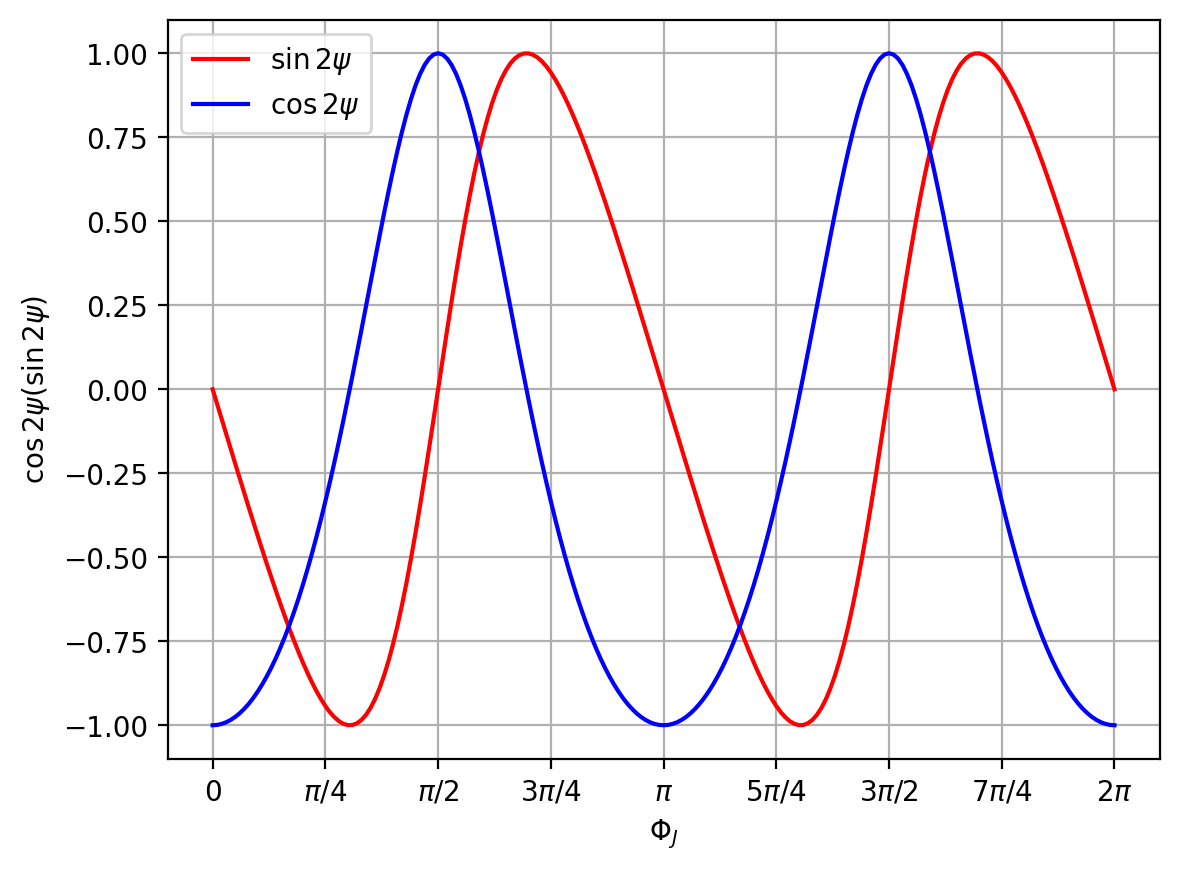

In [11]:
plt.plot(phi_J_arr, Z_J_2pa[:,1], color = 'r', label = r'$\sin2\psi$')
plt.plot(phi_J_arr, Z_J_2pa[:,0], color = 'b', label = r'$\cos2\psi$')
plt.xlabel(r'$\Phi_J$')
plt.ylabel(r'$\cos2\psi (\sin2\psi)$')
plt.xticks(np.arange(0, 2*np.pi + np.pi/4, np.pi/4), [r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$', r'$5\pi/4$', r'$3\pi/2$', r'$7\pi/4$', r'$2\pi$']);
plt.grid()
plt.legend()

Zero crossings for cos2pa at phi_J values:  [0.9424778  2.16769893 4.08407045 5.30929158]


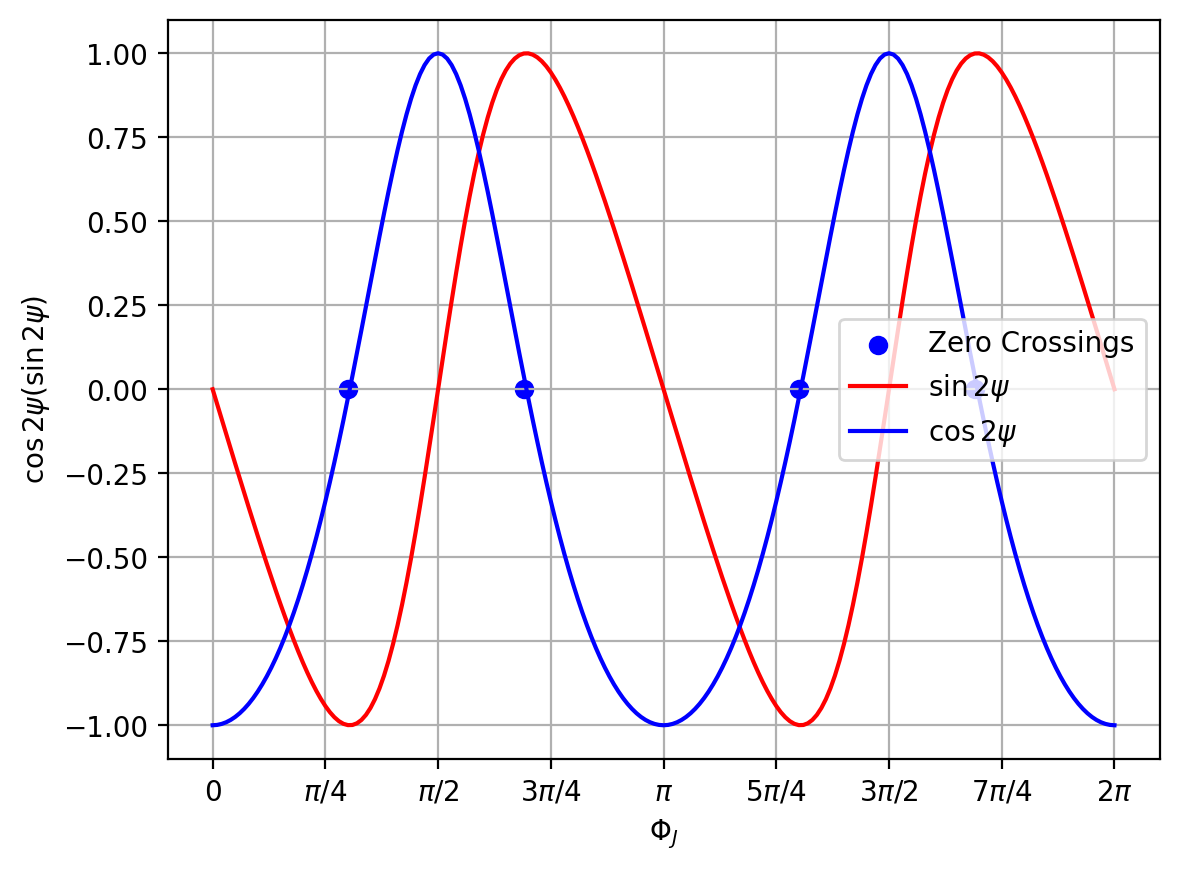

In [12]:
# Recording cos2pa zeros

len_cos = len(Z_J_2pa[:,0])

if Z_J_2pa[:,0][0]*Z_J_2pa[:,0][len_cos//4] < 0:
    zero_crossings_cos2pa = np.where(np.diff(np.sign(Z_J_2pa[:,0])))[0]
    zero_crossings_cos2pa_values = phi_J_arr[zero_crossings_cos2pa]
    print("Zero crossings for cos2pa at phi_J values: ", zero_crossings_cos2pa_values)

plt.scatter(zero_crossings_cos2pa_values, np.zeros_like(zero_crossings_cos2pa_values), color='b', marker='o', label='Zero Crossings')

plt.plot(phi_J_arr, Z_J_2pa[:,1], color = 'r', label = r'$\sin2\psi$')
plt.plot(phi_J_arr, Z_J_2pa[:,0], color = 'b', label = r'$\cos2\psi$')
plt.xlabel(r'$\Phi_J$')
plt.ylabel(r'$\cos2\psi (\sin2\psi)$')
plt.xticks(np.arange(0, 2*np.pi + np.pi/4, np.pi/4), [r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$', r'$5\pi/4$', r'$3\pi/2$', r'$7\pi/4$', r'$2\pi$']);
plt.grid()
plt.legend()


Text(0, 0.5, '$\\tilde{\\theta}$')

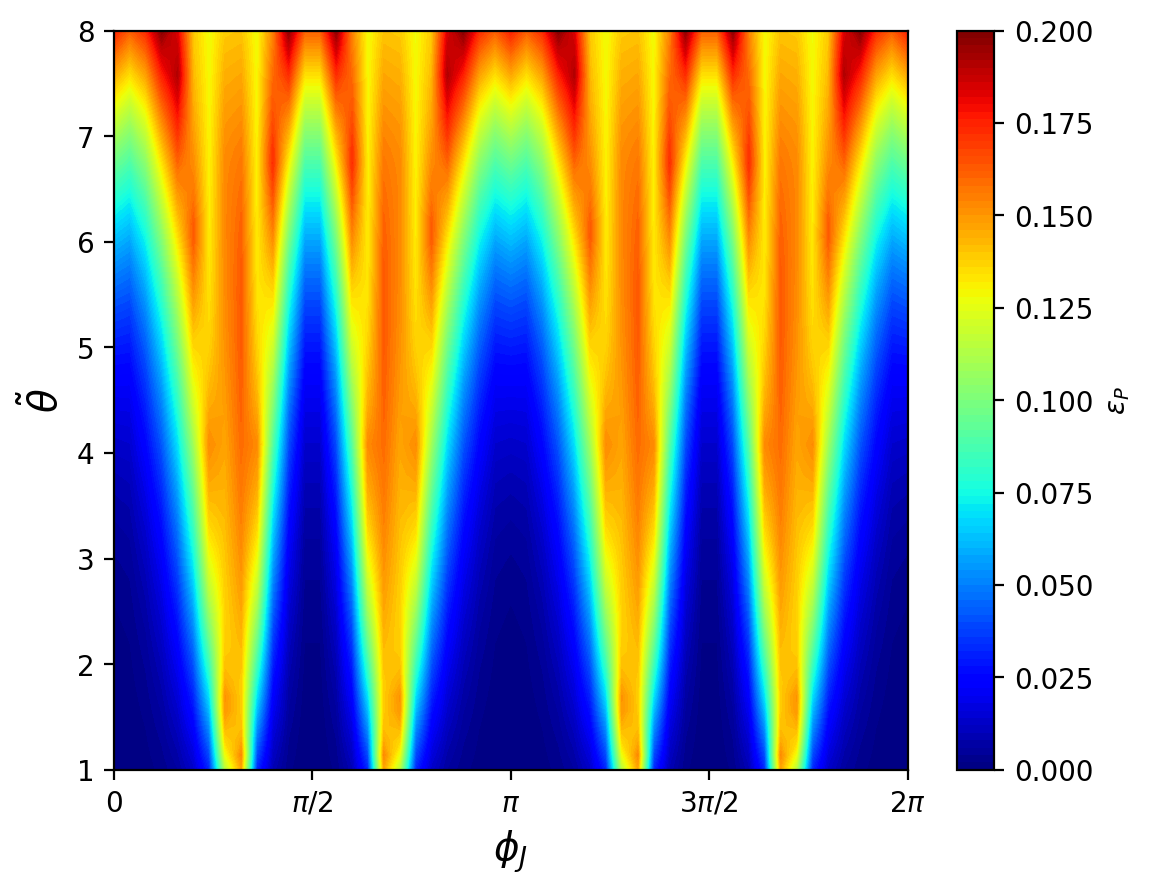

In [13]:
plt.contourf(phi_J_c_arr_hr, theta_tilde_arr_hr, Z_mismatch_EO_arr_o2_hr, cmap = 'jet', vmin=0, levels=100)
plt.colorbar(label=r'$\epsilon_P$', ticks = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.20])

plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
plt.xlabel(r'$\phi_J$', fontsize = 14)
plt.ylabel(r'$\tilde{\theta}$', fontsize = 14)

Text(0, 0.5, '$\\tilde{\\theta}$')

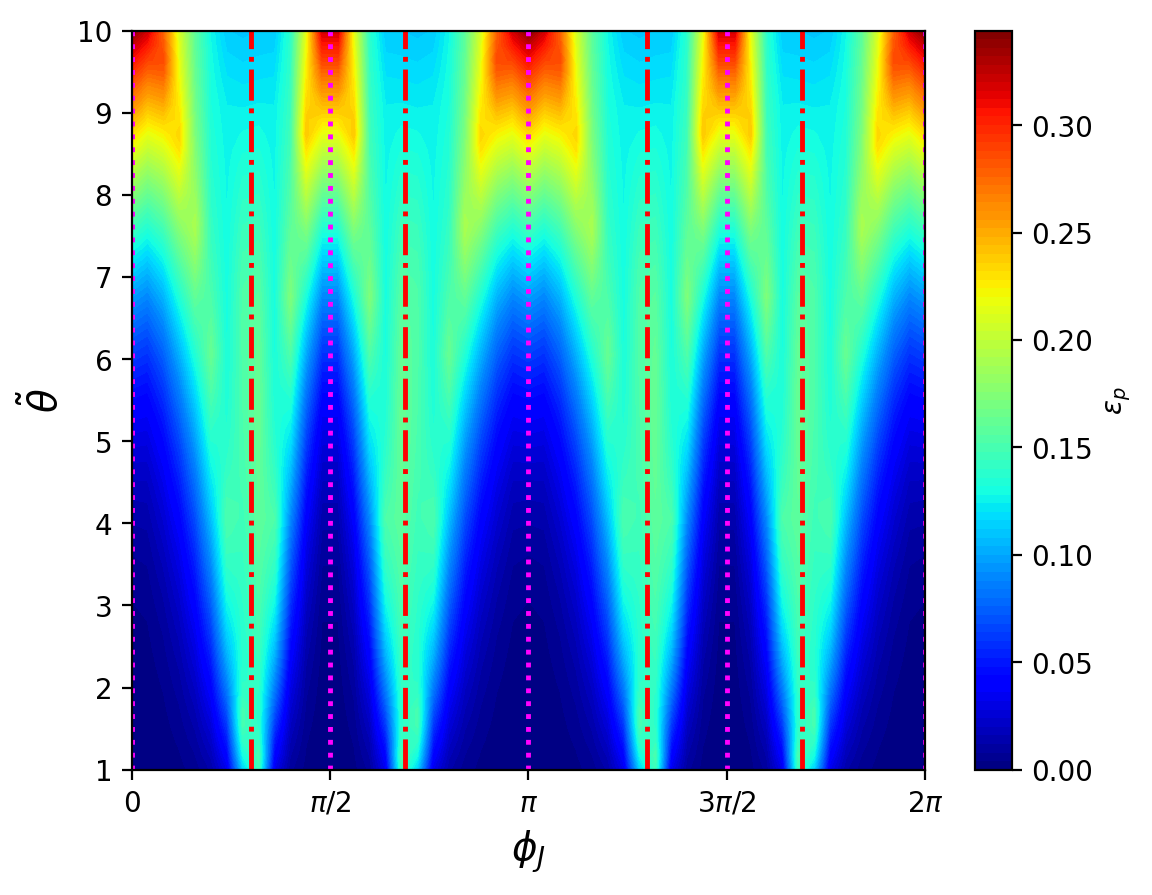

In [14]:
plt.contourf(phi_J_c_arr_hr, theta_tilde_arr_ext_hr, Z_mismatch_EO_arr_o2_ext_hr, cmap = 'jet', levels=100)
plt.colorbar(label=r'$\epsilon_p$', ticks = [0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40])

plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
plt.axvline(np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
plt.axvline(np.pi, color='magenta', linewidth=1.75, linestyle=':')
plt.axvline(3*np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
plt.axvline(0, color='magenta', linewidth=1.75, linestyle=':')
plt.axvline(2*np.pi, color='magenta', linewidth=1.75, linestyle=':')
plt.axvline(zero_crossings_cos2pa_values[0], color='r', linewidth=1.75, linestyle='-.')
plt.axvline(zero_crossings_cos2pa_values[1], color='r', linewidth=1.75, linestyle='-.')
plt.axvline(zero_crossings_cos2pa_values[2], color='r', linewidth=1.75, linestyle='-.')
plt.axvline(zero_crossings_cos2pa_values[3], color='r', linewidth=1.75, linestyle='-.')
plt.xlabel(r'$\phi_J$', fontsize = 14)
plt.ylabel(r'$\tilde{\theta}$', fontsize = 14)

Text(0, 0.5, '$\\tilde{\\Omega}$')

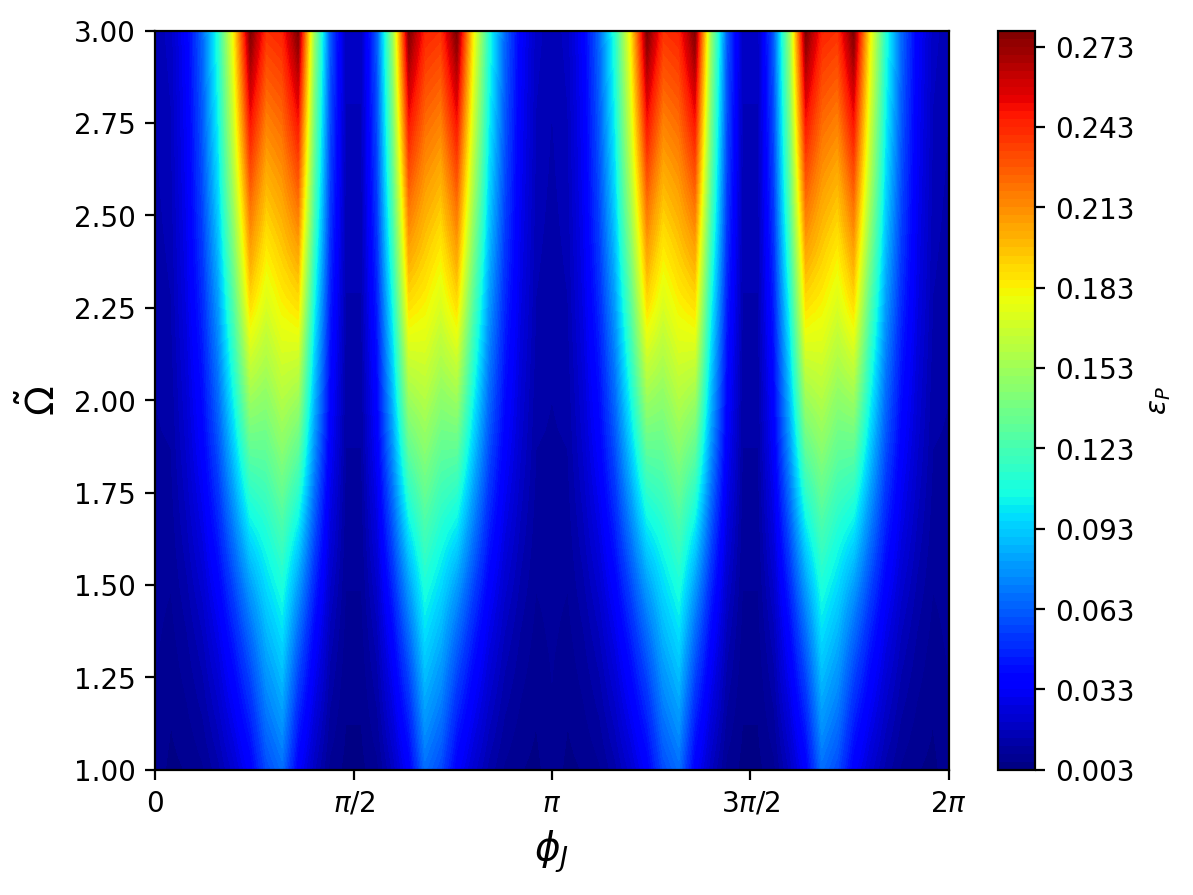

In [15]:
plt.contourf(phi_J_c_arr_hr, omega_tilde_arr_hr, Z_mismatch_EO_arr_t4_hr, cmap = 'jet', levels=100)
plt.colorbar(label=r'$\epsilon_P$')

plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
plt.xlabel(r'$\phi_J$', fontsize = 14)
plt.ylabel(r'$\tilde{\Omega}$', fontsize = 14)

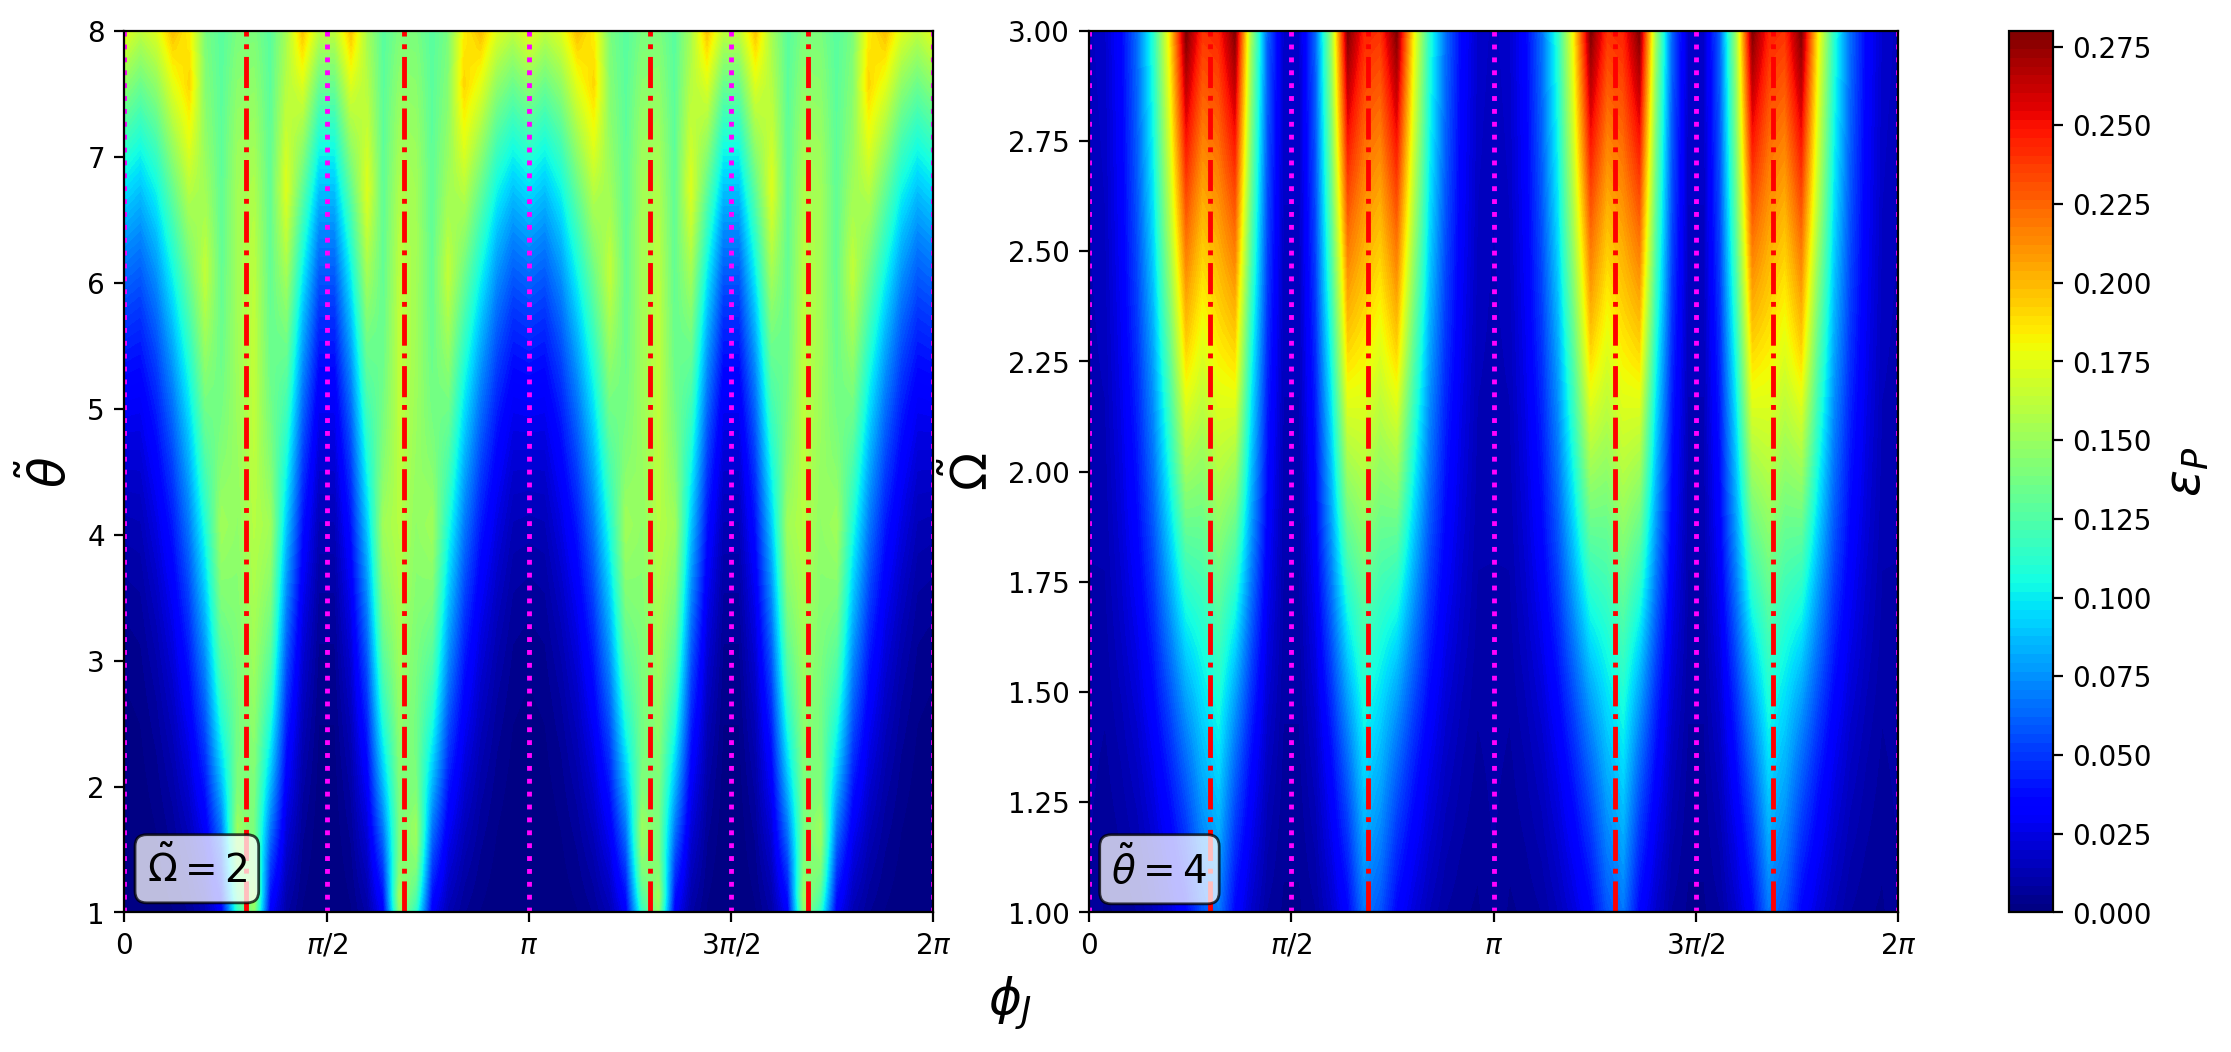

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=False, sharex=True)

color_levels_row = np.linspace(0, 0.28, 100)
color_map = 'jet'

contour = ax[0].contourf(phi_J_c_arr_hr, theta_tilde_arr_hr, Z_mismatch_EO_arr_o2_hr, color_levels_row, cmap=color_map, vmin = 0)
ax[1].contourf(phi_J_c_arr_hr, omega_tilde_arr_hr, Z_mismatch_EO_arr_t4_hr, color_levels_row, cmap=color_map, vmin = 0)

x_ticks = np.array([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
x_labels = [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']

ax[0].set_ylabel(r'$\tilde{\theta}$', fontsize = 18)
ax[1].set_ylabel(r'$\tilde{\Omega}$', fontsize = 18)

ax[0].set_xticks(x_ticks, x_labels)  # Corrected here
ax[1].set_xticks(x_ticks, x_labels)  # Corrected 

ax[0].axvline(np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(3*np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(0, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(2*np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(zero_crossings_cos2pa_values[0], color='r', linewidth=1.75, linestyle='-.')
ax[0].axvline(zero_crossings_cos2pa_values[1], color='r', linewidth=1.75, linestyle='-.')
ax[0].axvline(zero_crossings_cos2pa_values[2], color='r', linewidth=1.75, linestyle='-.')
ax[0].axvline(zero_crossings_cos2pa_values[3], color='r', linewidth=1.75, linestyle='-.')

ax[1].axvline(np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(3*np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(0, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(2*np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(zero_crossings_cos2pa_values[0], color='r', linewidth=1.75, linestyle='-.')
ax[1].axvline(zero_crossings_cos2pa_values[1], color='r', linewidth=1.75, linestyle='-.')
ax[1].axvline(zero_crossings_cos2pa_values[2], color='r', linewidth=1.75, linestyle='-.')
ax[1].axvline(zero_crossings_cos2pa_values[3], color='r', linewidth=1.75, linestyle='-.')

plt.tight_layout()

cbar = fig.colorbar(contour, ax=ax[:].ravel().tolist(), orientation='vertical', boundaries = np.linspace(0, 0.25, 21), ticks = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275])
# Add a colorbar
cbar.set_label(label=r'$\epsilon_P$', fontweight='bold', fontsize = 18) # Increase fontsize here

fig.text(x=0.425, y=-0.025, s=r'$\phi_{J}}$', ha='center', fontweight='bold', fontsize = 18)  

ax[0].text(0.0275, 0.075, r'$\tilde{\Omega} = 2$', transform=ax[0].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))
ax[1].text(0.0275, 0.075, r'$\tilde{\theta} = 4$', transform=ax[1].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

fig = plt.gcf()

#fig.savefig('figs/EO_mismatch_contours_o2_t4.pdf', bbox_inches='tight',format='pdf')


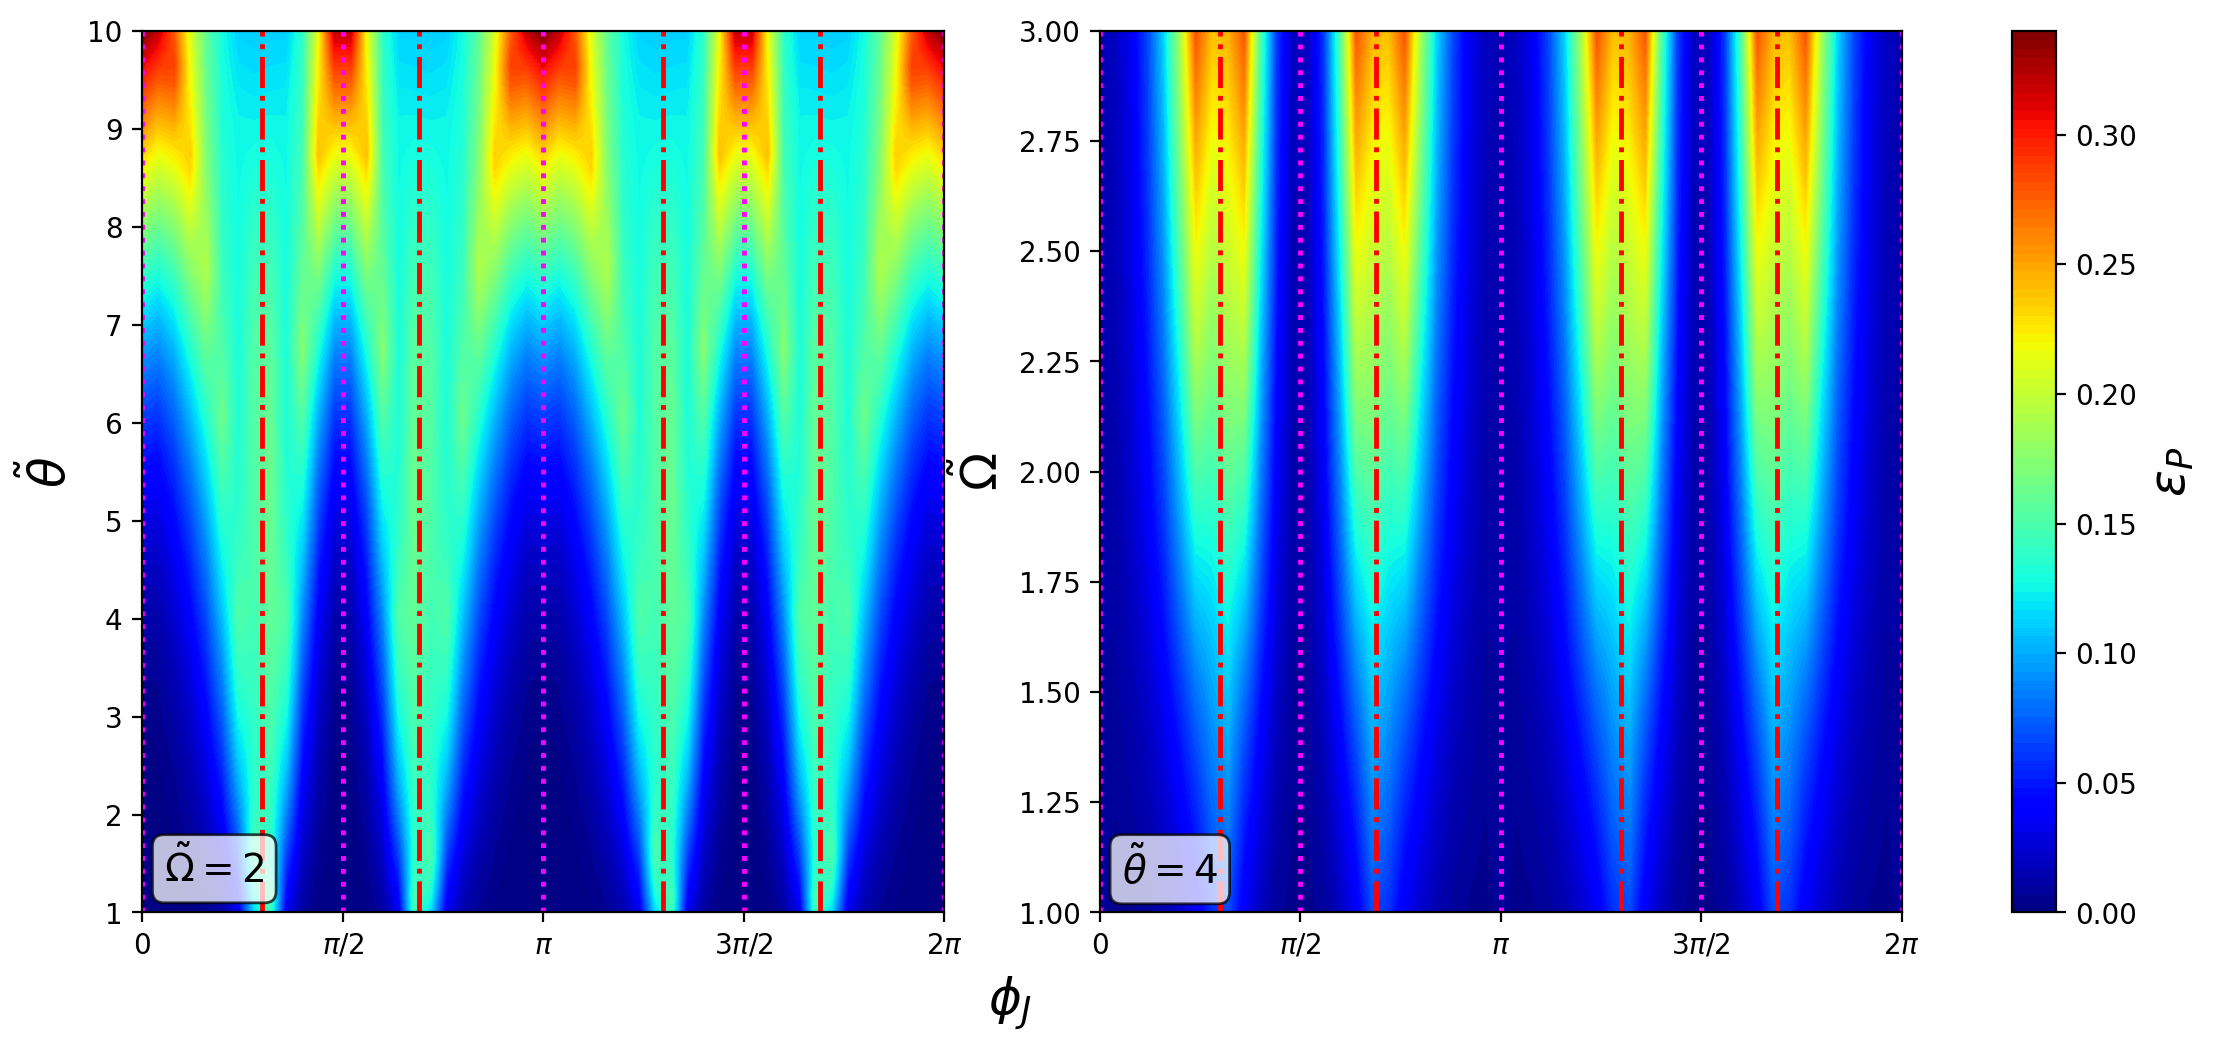

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=False, sharex=True)

color_levels_row = np.linspace(0, 0.34, 100)
color_map = 'jet'

contour = ax[0].contourf(phi_J_c_arr_hr, theta_tilde_arr_ext_hr, Z_mismatch_EO_arr_o2_ext_hr, color_levels_row, cmap=color_map, vmin = 0)
ax[1].contourf(phi_J_c_arr_hr, omega_tilde_arr_hr, Z_mismatch_EO_arr_t4_hr, color_levels_row, cmap=color_map, vmin = 0)

x_ticks = np.array([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
x_labels = [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']

ax[0].set_ylabel(r'$\tilde{\theta}$', fontsize = 18)
ax[1].set_ylabel(r'$\tilde{\Omega}$', fontsize = 18)

ax[0].set_xticks(x_ticks, x_labels)  # Corrected here
ax[1].set_xticks(x_ticks, x_labels)  # Corrected here

ax[0].axvline(np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(3*np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(0, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(2*np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(zero_crossings_cos2pa_values[0], color='r', linewidth=1.75, linestyle='-.')
ax[0].axvline(zero_crossings_cos2pa_values[1], color='r', linewidth=1.75, linestyle='-.')
ax[0].axvline(zero_crossings_cos2pa_values[2], color='r', linewidth=1.75, linestyle='-.')
ax[0].axvline(zero_crossings_cos2pa_values[3], color='r', linewidth=1.75, linestyle='-.')

ax[1].axvline(np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(3*np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(0, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(2*np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(zero_crossings_cos2pa_values[0], color='r', linewidth=1.75, linestyle='-.')
ax[1].axvline(zero_crossings_cos2pa_values[1], color='r', linewidth=1.75, linestyle='-.')
ax[1].axvline(zero_crossings_cos2pa_values[2], color='r', linewidth=1.75, linestyle='-.')
ax[1].axvline(zero_crossings_cos2pa_values[3], color='r', linewidth=1.75, linestyle='-.')

plt.tight_layout()

cbar = fig.colorbar(contour, ax=ax[:].ravel().tolist(), orientation='vertical', boundaries = np.linspace(0, 0.25, 21), ticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# Add a colorbar
cbar.set_label(label=r'$\epsilon_P$', fontweight='bold', fontsize = 18) # Increase fontsize here

fig.text(x=0.425, y=-0.025, s=r'$\phi_{J}}$', ha='center', fontweight='bold', fontsize = 18)

ax[0].text(0.0275, 0.075, r'$\tilde{\Omega} = 2$', transform=ax[0].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))
ax[1].text(0.0275, 0.075, r'$\tilde{\theta} = 4$', transform=ax[1].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

fig = plt.gcf()

fig.savefig('figs/EO_mismatch_contours_o2_t4_t_ext.pdf', bbox_inches='tight',format='pdf')

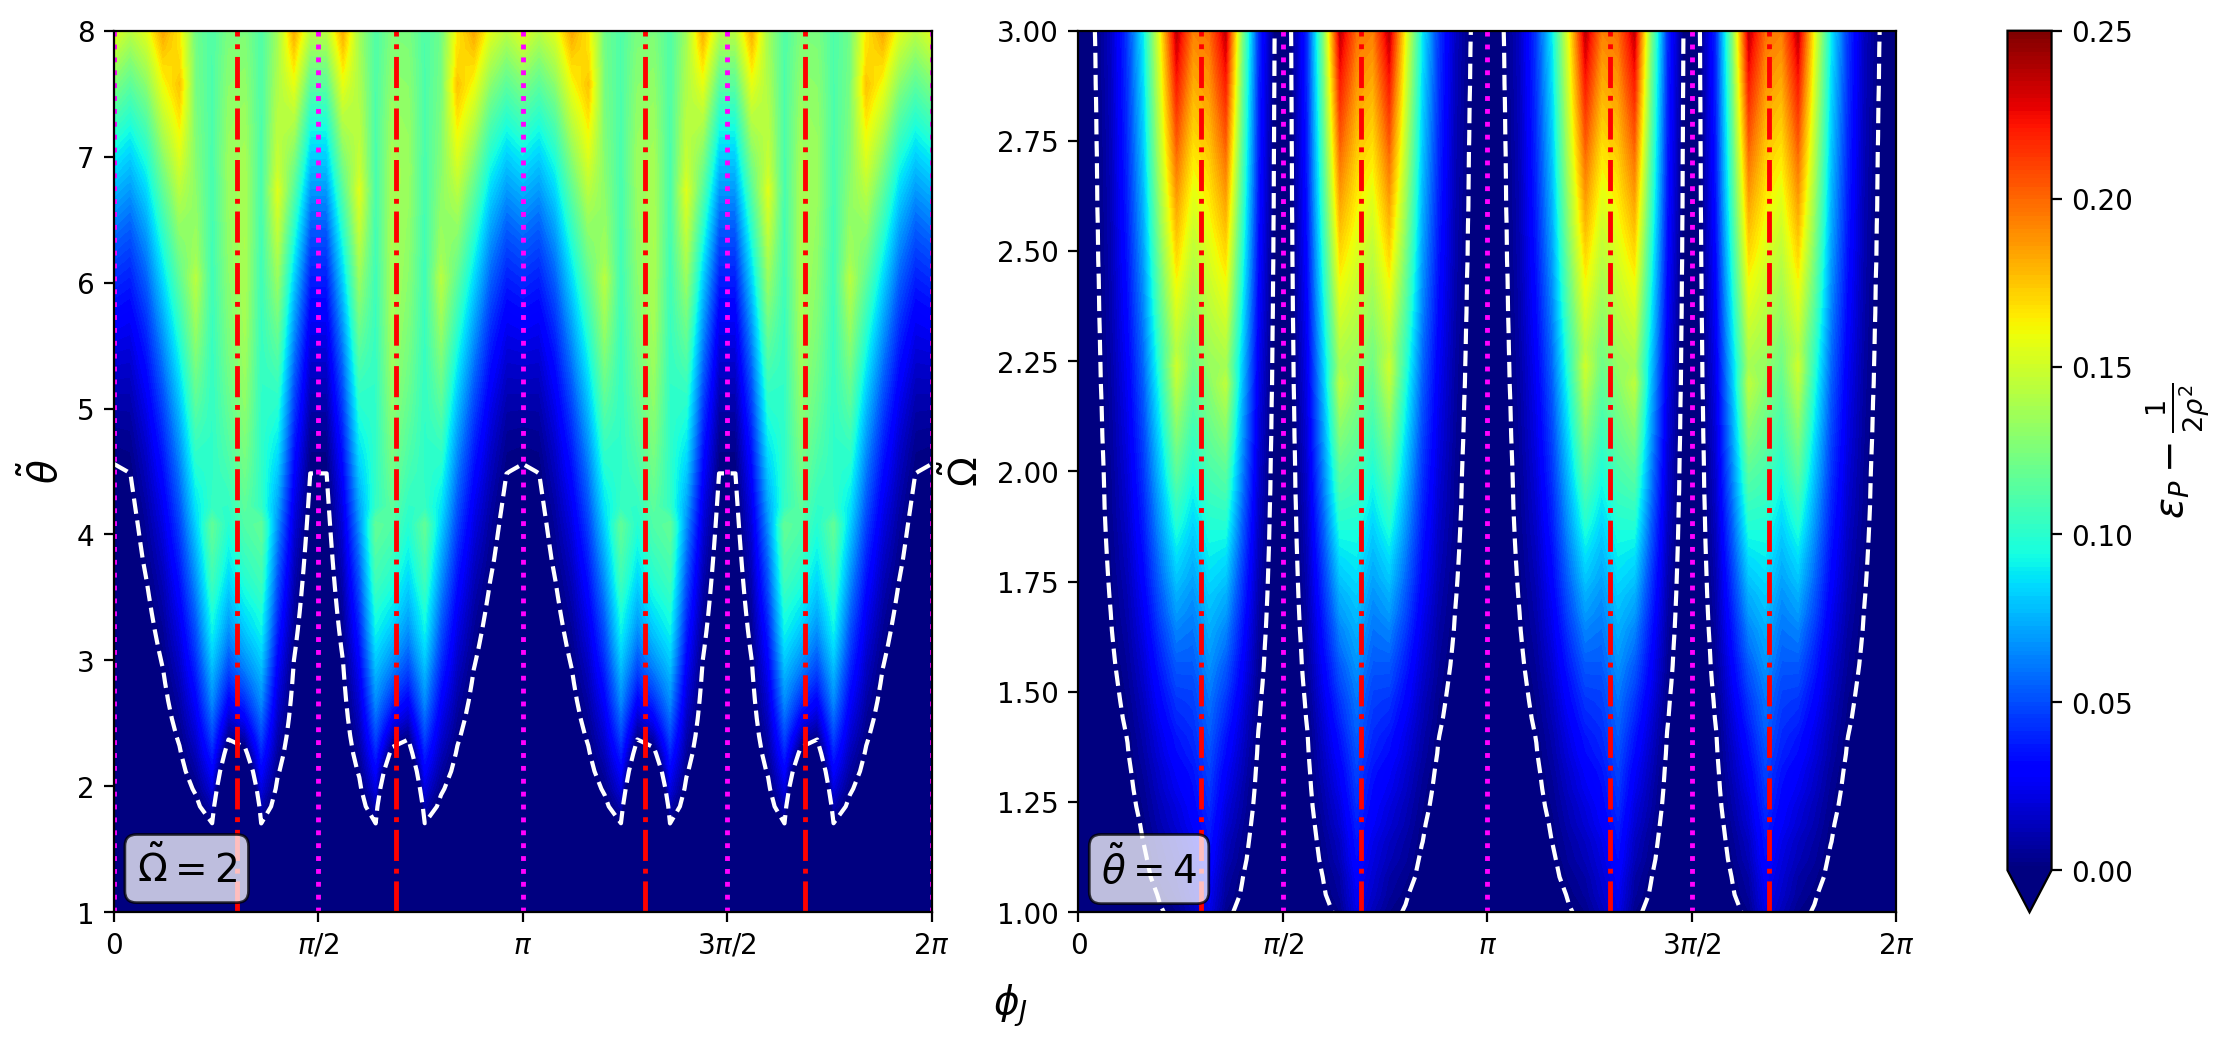

In [18]:
# We can also do Linblom inequality - older version - minimization over gamma_p is not done correctly

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=False, sharex=True)

color_levels_row = np.linspace(-0.35, 0.25, 200)
color_map = 'jet'

contour = ax[0].contourf(phi_J_c_arr_hr, theta_tilde_arr_hr, Z_lindblom_EO_arr_o2_hr, levels=color_levels_row, cmap=color_map, vmin = 0)
ax[1].contourf(phi_J_c_arr_hr, omega_tilde_arr_hr, Z_lindblom_EO_arr_t4_hr, levels=color_levels_row, cmap=color_map, vmin = 0)

ax[0].contour(phi_J_c_arr_hr, theta_tilde_arr_hr, Z_lindblom_EO_arr_o2_hr, levels=[0], linestyles='dashed', colors='white')
ax[1].contour(phi_J_c_arr_hr, omega_tilde_arr_hr, Z_lindblom_EO_arr_t4_hr, levels=[0], linestyles='dashed', colors='white')

x_ticks = np.array([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
x_labels = [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']

ax[0].set_ylabel(r'$\tilde{\theta}$', fontsize = 14)
ax[1].set_ylabel(r'$\tilde{\Omega}$', fontsize = 14)

ax[0].set_xticks(x_ticks, x_labels)  # Corrected here
ax[1].set_xticks(x_ticks, x_labels)  # Corrected here

ax[0].axvline(np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(3*np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(0, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(2*np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(zero_crossings_cos2pa_values[0], color='r', linewidth=1.75, linestyle='-.')
ax[0].axvline(zero_crossings_cos2pa_values[1], color='r', linewidth=1.75, linestyle='-.')
ax[0].axvline(zero_crossings_cos2pa_values[2], color='r', linewidth=1.75, linestyle='-.')
ax[0].axvline(zero_crossings_cos2pa_values[3], color='r', linewidth=1.75, linestyle='-.')

ax[1].axvline(np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(3*np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(zero_crossings_cos2pa_values[0], color='r', linewidth=1.75, linestyle='-.')
ax[1].axvline(zero_crossings_cos2pa_values[1], color='r', linewidth=1.75, linestyle='-.')
ax[1].axvline(zero_crossings_cos2pa_values[2], color='r', linewidth=1.75, linestyle='-.')
ax[1].axvline(zero_crossings_cos2pa_values[3], color='r', linewidth=1.75, linestyle='-.')

plt.tight_layout()

# Set the colorbar
norm = Normalize(vmin=0, vmax=0.25)
sm = ScalarMappable(cmap=color_map, norm=norm)
sm.set_array([])

# Add a colorbar
cbar = fig.colorbar(sm, ax=ax[:].ravel().tolist(), orientation='vertical', boundaries = np.linspace(0, 0.25, 200), ticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25], extend='min')

cbar.set_label(label=r'$\epsilon_P - \frac{1}{2\rho^2}$', fontweight='bold', fontsize = 14) # Increase fontsize here

fig.text(x=0.425, y=-0.025, s=r'$\phi_{J}}$', ha='center', fontweight='bold', fontsize = 14) 

ax[0].text(0.0275, 0.075, r'$\tilde{\Omega} = 2$', transform=ax[0].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))
ax[1].text(0.0275, 0.075, r'$\tilde{\theta} = 4$', transform=ax[1].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

fig = plt.gcf()

#fig.savefig('figs/EO_lindblom_contours_o2_t4.pdf', bbox_inches='tight',format='pdf')

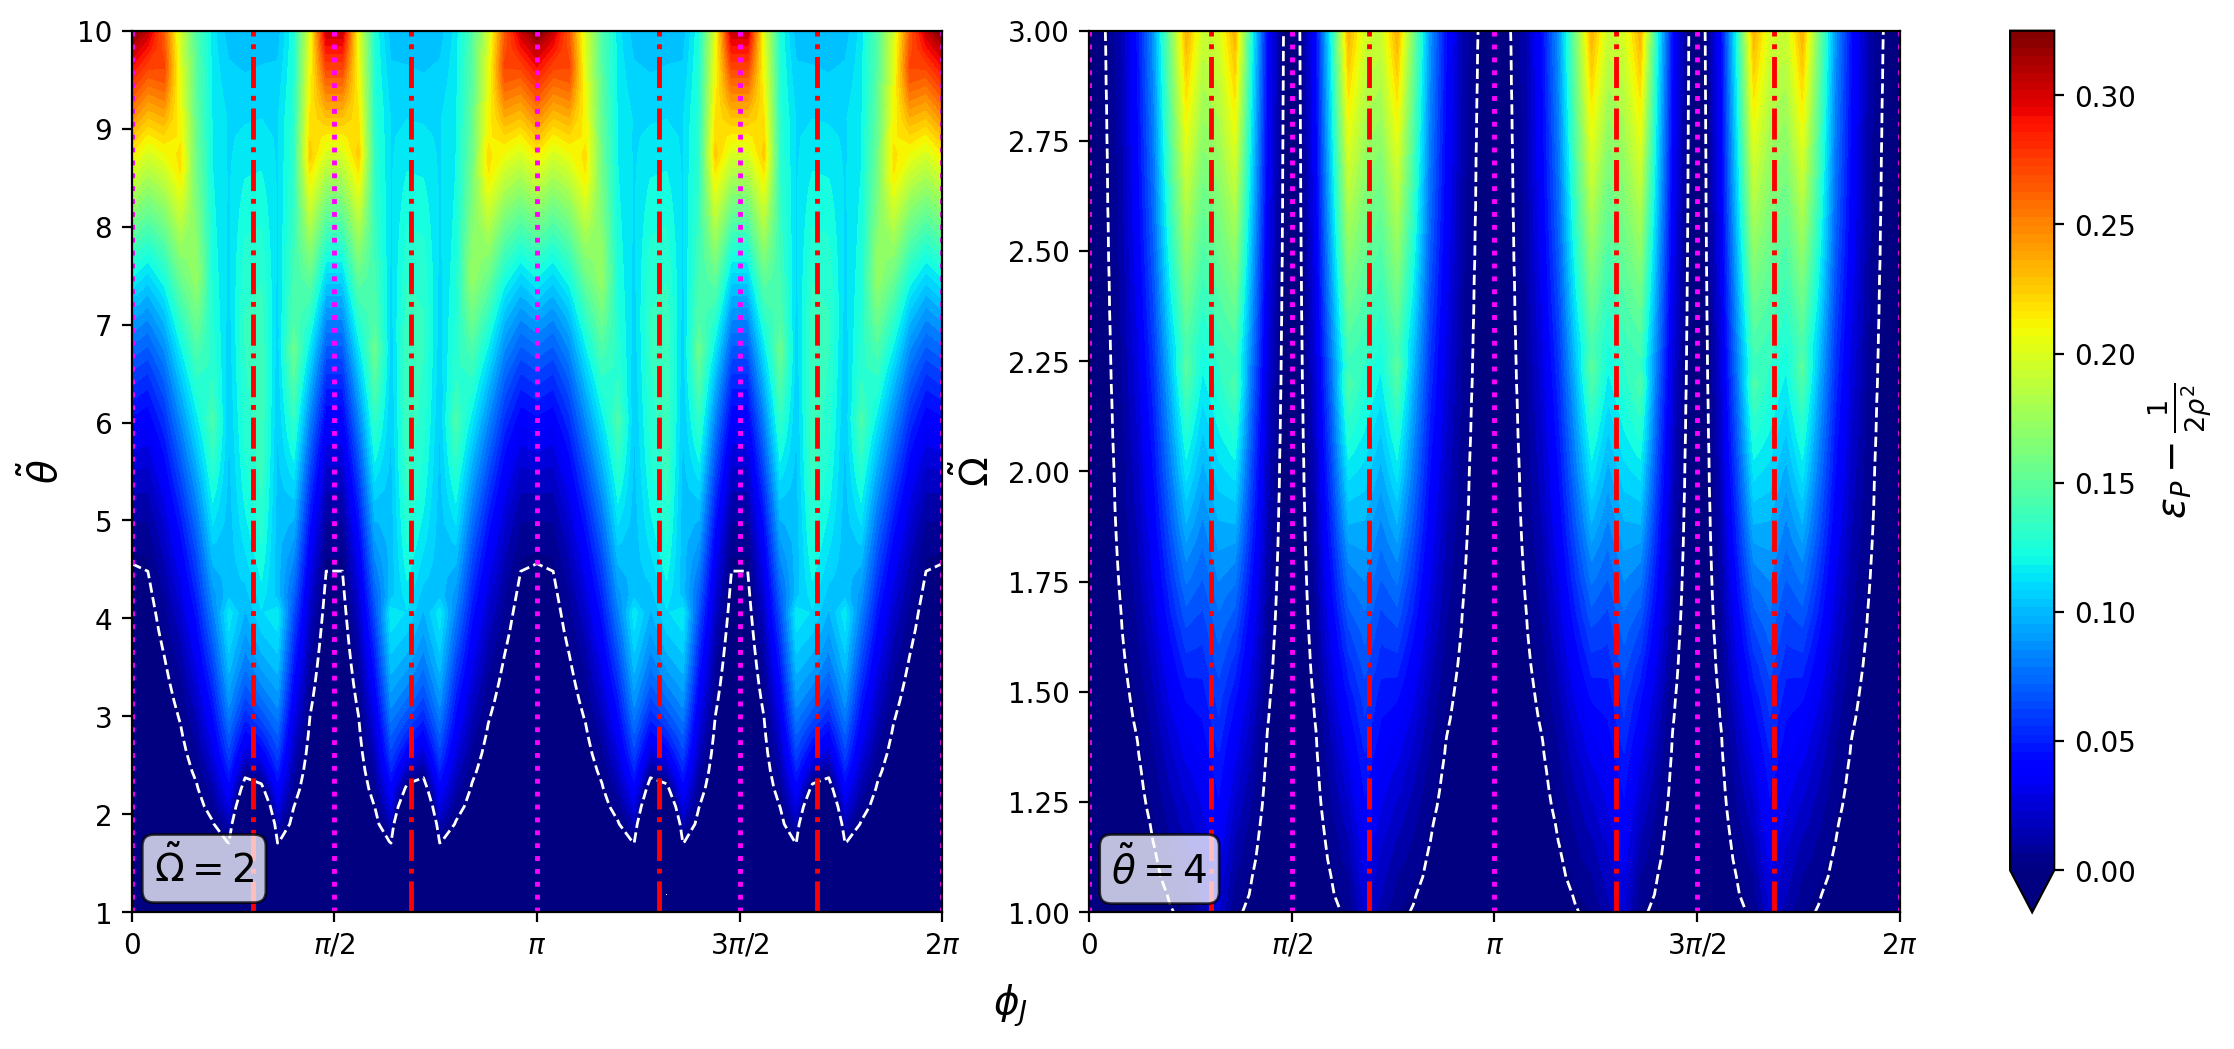

In [19]:
# older version - minimization over gamma_p is not done correctly
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=False, sharex=True)

color_levels_row = np.linspace(-0.355, 0.325, 100)
color_map = 'jet'

contour = ax[0].contourf(phi_J_c_arr_hr, theta_tilde_arr_ext_hr, Z_lindblom_EO_arr_o2_ext_hr, levels=color_levels_row, cmap=color_map, vmin = 0)
ax[1].contourf(phi_J_c_arr_hr, omega_tilde_arr_hr, Z_lindblom_EO_arr_t4_hr, levels=color_levels_row, cmap=color_map, vmin = 0)

ax[0].contour(phi_J_c_arr_hr, theta_tilde_arr_ext_hr, Z_lindblom_EO_arr_o2_ext_hr, levels=[0], colors='white', linewidths=1, linestyles='dashed')
ax[1].contour(phi_J_c_arr_hr, omega_tilde_arr_hr, Z_lindblom_EO_arr_t4_hr, levels=[0], colors='white', linewidths=1, linestyles='dashed')

x_ticks = np.array([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
x_labels = [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']

ax[0].set_ylabel(r'$\tilde{\theta}$', fontsize = 14)
ax[1].set_ylabel(r'$\tilde{\Omega}$', fontsize = 14)

ax[0].set_xticks(x_ticks, x_labels)  # Corrected here
ax[1].set_xticks(x_ticks, x_labels)  # Corrected here

ax[0].axvline(np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(3*np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(0, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(2*np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(zero_crossings_cos2pa_values[0], color='r', linewidth=1.75, linestyle='-.')
ax[0].axvline(zero_crossings_cos2pa_values[1], color='r', linewidth=1.75, linestyle='-.')
ax[0].axvline(zero_crossings_cos2pa_values[2], color='r', linewidth=1.75, linestyle='-.')
ax[0].axvline(zero_crossings_cos2pa_values[3], color='r', linewidth=1.75, linestyle='-.')

ax[1].axvline(np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(3*np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(0, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(2*np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(zero_crossings_cos2pa_values[0], color='r', linewidth=1.75, linestyle='-.')
ax[1].axvline(zero_crossings_cos2pa_values[1], color='r', linewidth=1.75, linestyle='-.')
ax[1].axvline(zero_crossings_cos2pa_values[2], color='r', linewidth=1.75, linestyle='-.')
ax[1].axvline(zero_crossings_cos2pa_values[3], color='r', linewidth=1.75, linestyle='-.')

plt.tight_layout()

norm = Normalize(vmin=0, vmax=0.325)
sm = ScalarMappable(cmap=color_map, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax[:].ravel().tolist(), orientation='vertical', boundaries = np.linspace(0.0, 0.325, 100), ticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3], extend='min')
# Add a colorbar
cbar.set_label(label=r'$\epsilon_P - \frac{1}{2\rho^2}$', fontweight='bold', fontsize = 14) # Increase fontsize here

fig.text(x=0.425, y=-0.025, s=r'$\phi_{J}}$', ha='center', fontweight='bold', fontsize = 14) 

ax[0].text(0.0275, 0.075, r'$\tilde{\Omega} = 2$', transform=ax[0].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))
ax[1].text(0.0275, 0.075, r'$\tilde{\theta} = 4$', transform=ax[1].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

fig = plt.gcf()

#fig.savefig('figs/EO_lindblom_contours_o2_t4_t_ext.pdf', bbox_inches='tight',format='pdf')

Highest res:

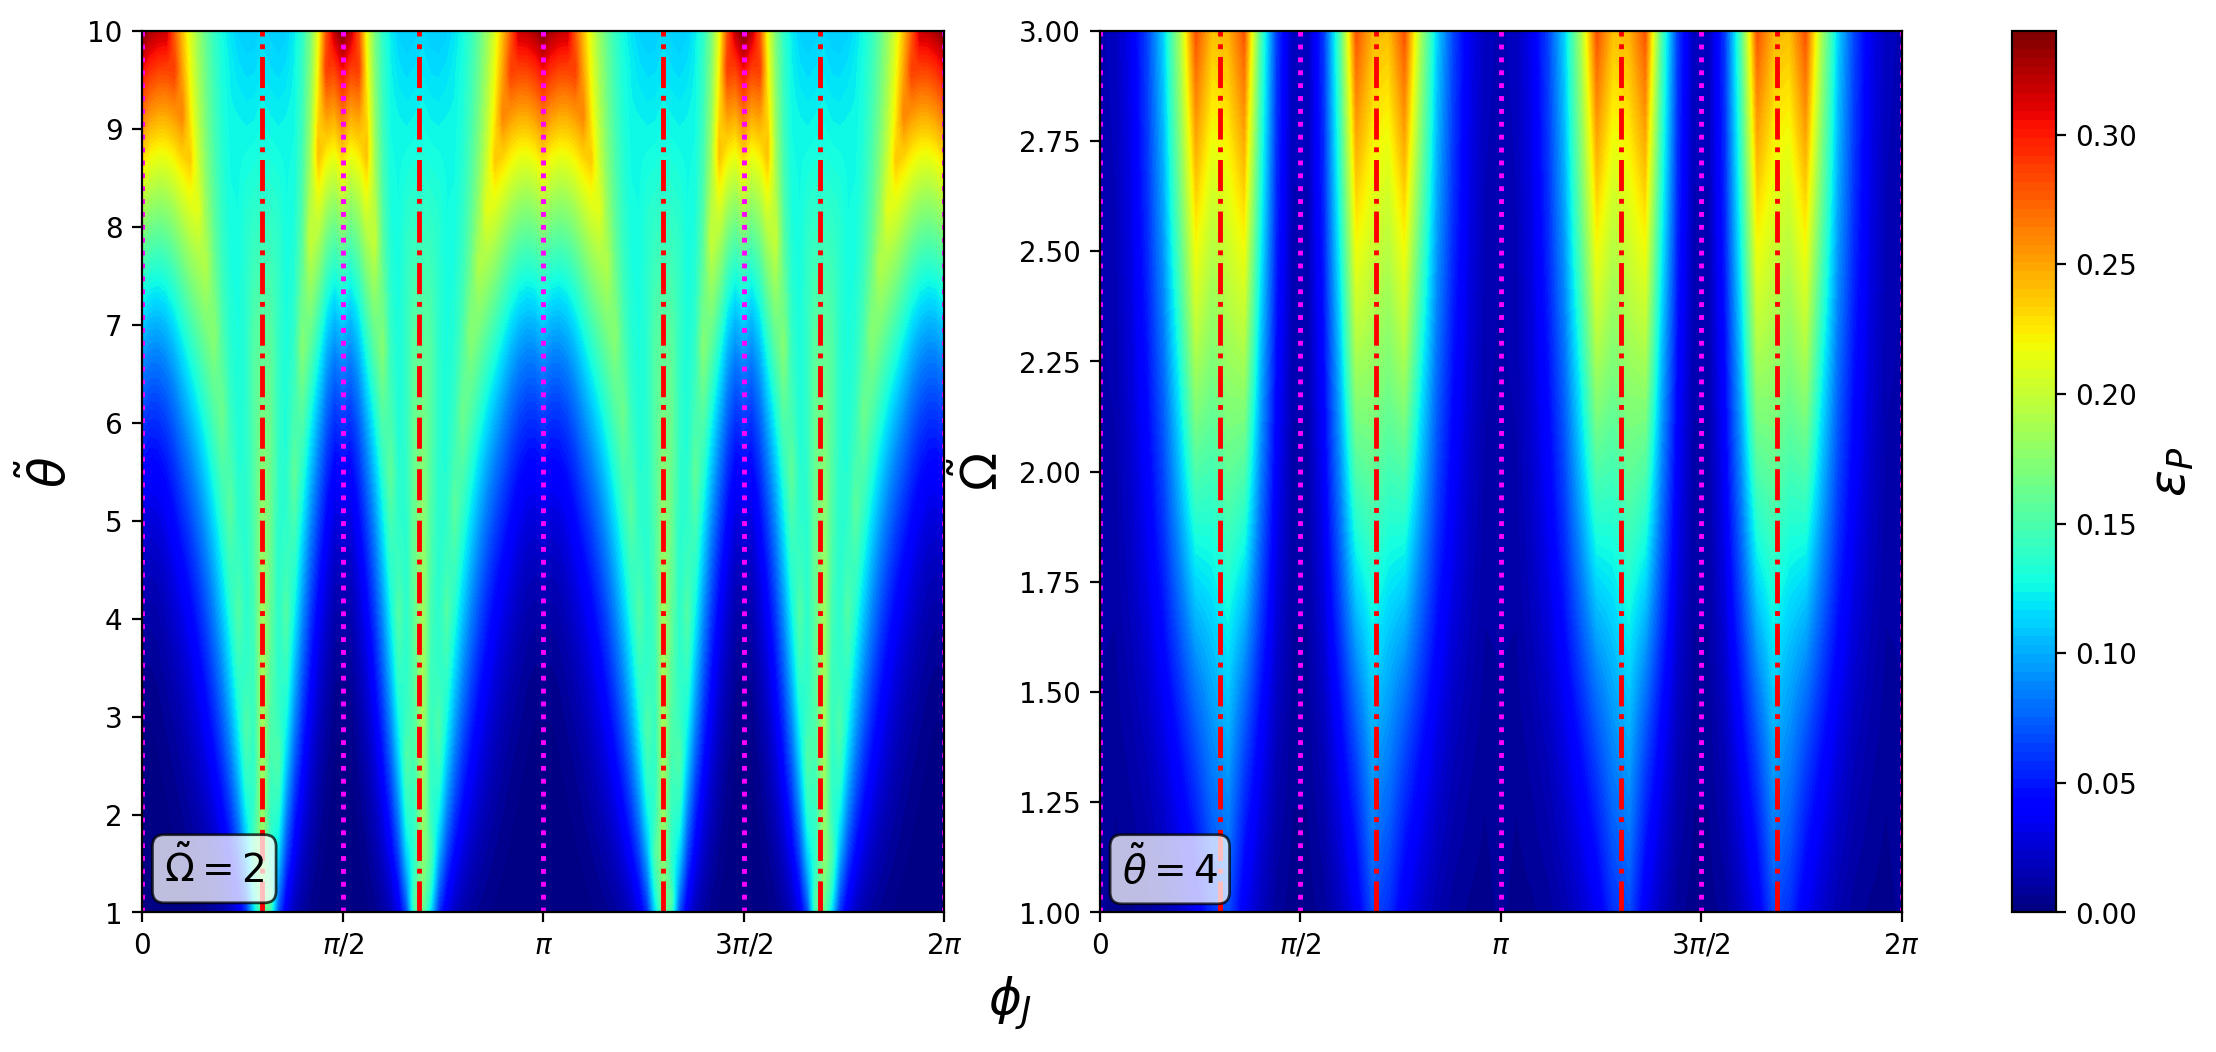

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=False, sharex=True)

color_levels_row = np.linspace(0, 0.34, 100)
color_map = 'jet'

contour = ax[0].contourf(phi_J_c_arr_highest_res, theta_tilde_arr_ext_highest_res, Z_mismatch_EO_arr_o2_highest_res, color_levels_row, cmap=color_map, vmin = 0)
ax[1].contourf(phi_J_c_arr_hr, omega_tilde_arr_hr, Z_mismatch_EO_arr_t4_hr, color_levels_row, cmap=color_map, vmin = 0)

x_ticks = np.array([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
x_labels = [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']

ax[0].set_ylabel(r'$\tilde{\theta}$', fontsize = 18)
ax[1].set_ylabel(r'$\tilde{\Omega}$', fontsize = 18)

ax[0].set_xticks(x_ticks, x_labels)  # Corrected here
ax[1].set_xticks(x_ticks, x_labels)  # Corrected here

ax[0].axvline(np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(3*np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(0, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(2*np.pi, color='magenta', linewidth=1.75, linestyle=':')

ax[0].axvline(zero_crossings_cos2pa_values[0], color='r', linewidth=1.75, linestyle='-.')
ax[0].axvline(zero_crossings_cos2pa_values[1], color='r', linewidth=1.75, linestyle='-.')
ax[0].axvline(zero_crossings_cos2pa_values[2], color='r', linewidth=1.75, linestyle='-.')
ax[0].axvline(zero_crossings_cos2pa_values[3], color='r', linewidth=1.75, linestyle='-.')

ax[1].axvline(np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(3*np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(0, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(2*np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(zero_crossings_cos2pa_values[0], color='r', linewidth=1.75, linestyle='-.')
ax[1].axvline(zero_crossings_cos2pa_values[1], color='r', linewidth=1.75, linestyle='-.')
ax[1].axvline(zero_crossings_cos2pa_values[2], color='r', linewidth=1.75, linestyle='-.')
ax[1].axvline(zero_crossings_cos2pa_values[3], color='r', linewidth=1.75, linestyle='-.')

plt.tight_layout()


cbar = fig.colorbar(contour, ax=ax[:].ravel().tolist(), orientation='vertical', boundaries = np.linspace(0, 0.325, 21), ticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# Add a colorbar
cbar.set_label(label=r'$\epsilon_P$', fontweight='bold', fontsize = 18) # Increase fontsize here

fig.text(x=0.425, y=-0.025, s=r'$\phi_{J}}$', ha='center', fontweight='bold', fontsize = 18) 

ax[0].text(0.0275, 0.075, r'$\tilde{\Omega} = 2$', transform=ax[0].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))
ax[1].text(0.0275, 0.075, r'$\tilde{\theta} = 4$', transform=ax[1].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

fig = plt.gcf()

fig.savefig('figs/EO_mismatch_contours_o2_t4_t_ext_hr.pdf', bbox_inches='tight',format='pdf')

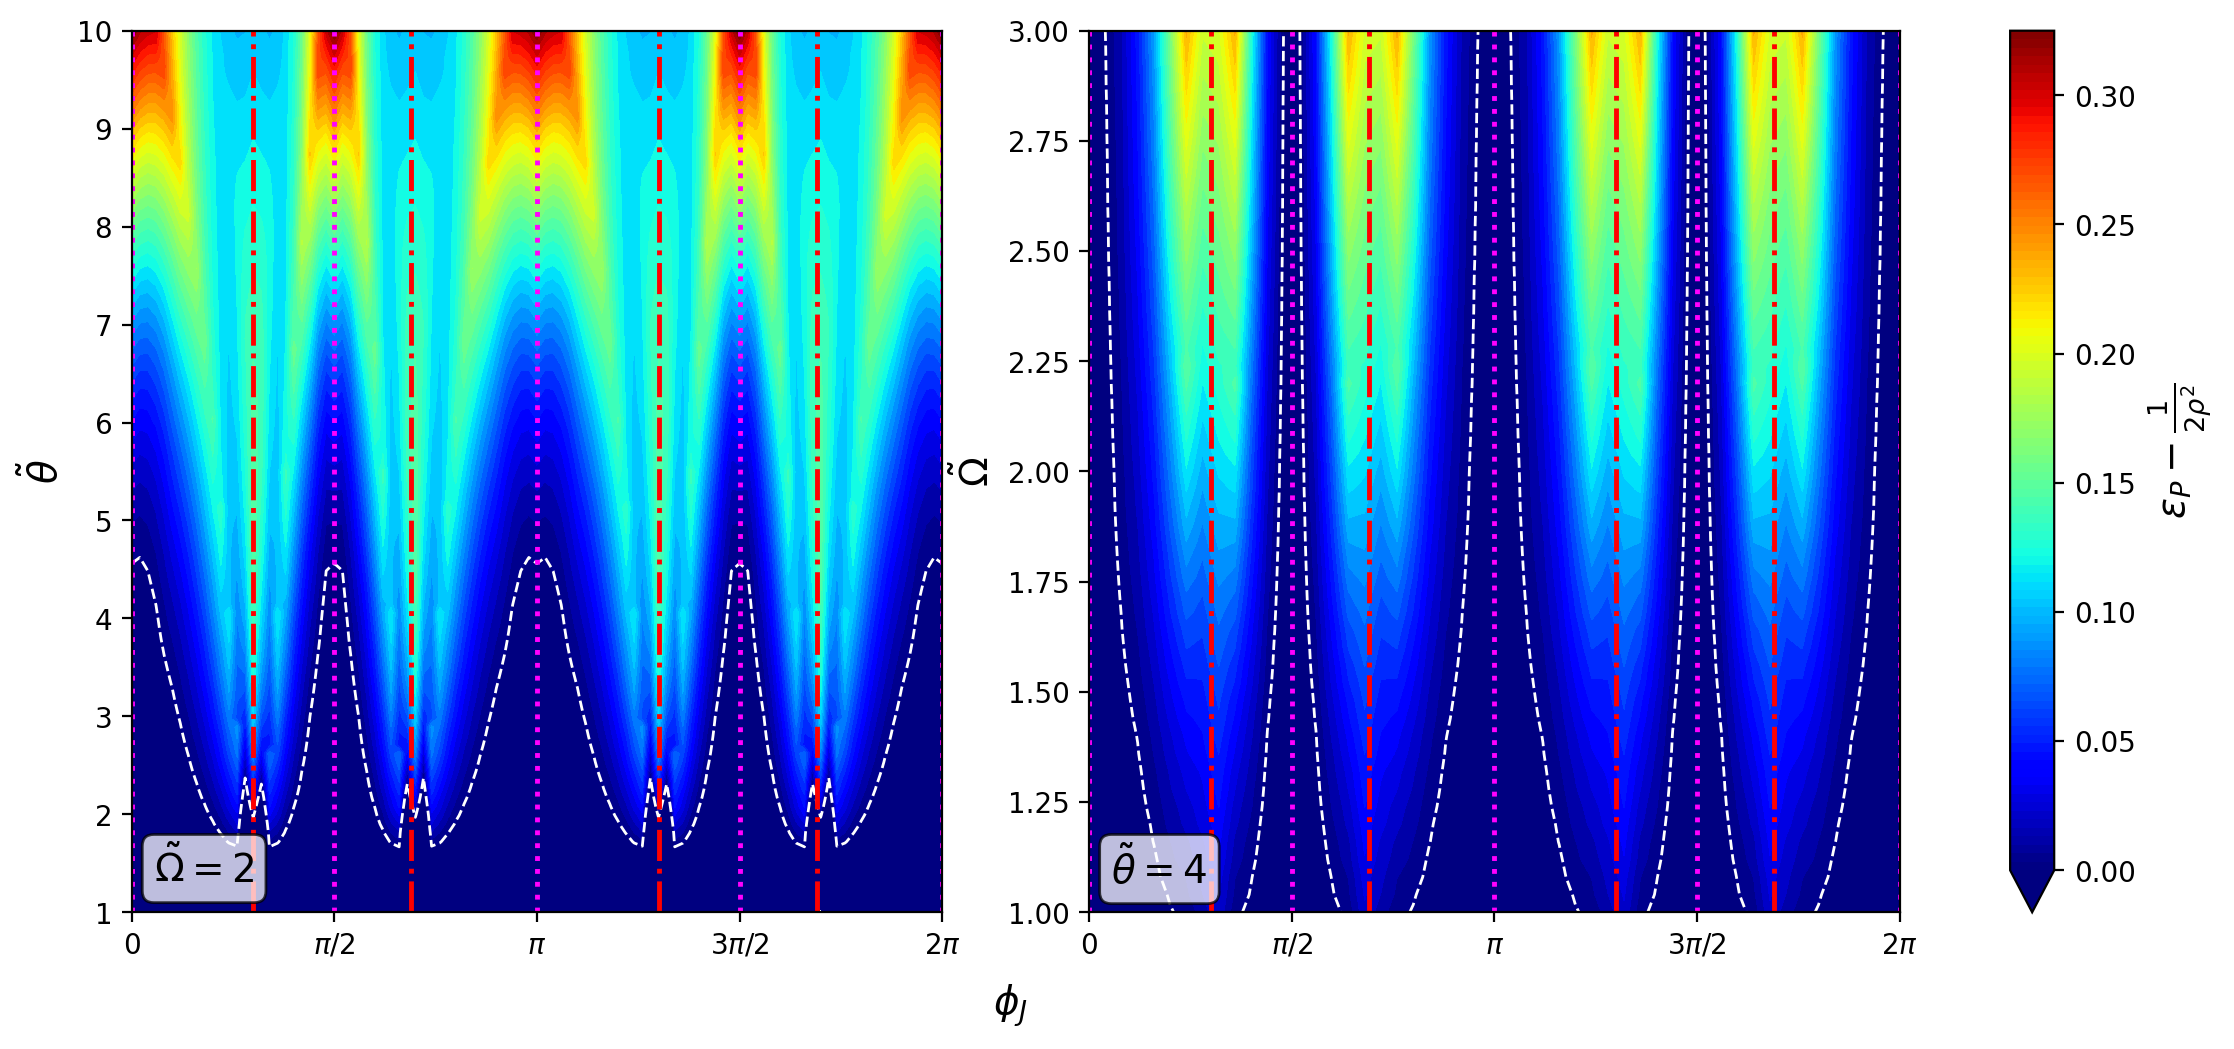

In [21]:
# again older version - minimization over gamma_p is not done correctly
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=False, sharex=True)

color_levels_row = np.linspace(-0.5, 0.325, 100)
color_map = 'jet'

contour = ax[0].contourf(phi_J_c_arr_highest_res, theta_tilde_arr_ext_highest_res, Z_lindblom_EO_arr_o2_highest_res, levels=color_levels_row, cmap=color_map, vmin = 0)
ax[1].contourf(phi_J_c_arr_hr, omega_tilde_arr_hr, Z_lindblom_EO_arr_t4_hr, levels=color_levels_row, cmap=color_map, vmin = 0)

ax[0].contour(phi_J_c_arr_highest_res, theta_tilde_arr_ext_highest_res, Z_lindblom_EO_arr_o2_highest_res, levels=[0], colors='white', linewidths=1, linestyles='dashed')
ax[1].contour(phi_J_c_arr_hr, omega_tilde_arr_hr, Z_lindblom_EO_arr_t4_hr, levels=[0], colors='white', linewidths=1, linestyles='dashed')

x_ticks = np.array([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
x_labels = [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']

ax[0].set_ylabel(r'$\tilde{\theta}$', fontsize = 14)
ax[1].set_ylabel(r'$\tilde{\Omega}$', fontsize = 14)

ax[0].set_xticks(x_ticks, x_labels)  # Corrected here
ax[1].set_xticks(x_ticks, x_labels)  # Corrected here

ax[0].axvline(np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(3*np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(0, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(2*np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[0].axvline(zero_crossings_cos2pa_values[0], color='r', linewidth=1.75, linestyle='-.')
ax[0].axvline(zero_crossings_cos2pa_values[1], color='r', linewidth=1.75, linestyle='-.')
ax[0].axvline(zero_crossings_cos2pa_values[2], color='r', linewidth=1.75, linestyle='-.')
ax[0].axvline(zero_crossings_cos2pa_values[3], color='r', linewidth=1.75, linestyle='-.')

ax[1].axvline(np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(3*np.pi/2, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(0, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(2*np.pi, color='magenta', linewidth=1.75, linestyle=':')
ax[1].axvline(zero_crossings_cos2pa_values[0], color='r', linewidth=1.75, linestyle='-.')
ax[1].axvline(zero_crossings_cos2pa_values[1], color='r', linewidth=1.75, linestyle='-.')
ax[1].axvline(zero_crossings_cos2pa_values[2], color='r', linewidth=1.75, linestyle='-.')
ax[1].axvline(zero_crossings_cos2pa_values[3], color='r', linewidth=1.75, linestyle='-.')

plt.tight_layout()

norm = Normalize(vmin=0, vmax=0.325)
sm = ScalarMappable(cmap=color_map, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax[:].ravel().tolist(), orientation='vertical', boundaries = np.linspace(0.0, 0.325, 100), ticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3], extend='min')
# Add a colorbar
cbar.set_label(label=r'$\epsilon_P - \frac{1}{2\rho^2}$', fontweight='bold', fontsize = 14) # Increase fontsize here

fig.text(x=0.425, y=-0.025, s=r'$\phi_{J}}$', ha='center', fontweight='bold', fontsize = 14)

ax[0].text(0.0275, 0.075, r'$\tilde{\Omega} = 2$', transform=ax[0].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))
ax[1].text(0.0275, 0.075, r'$\tilde{\theta} = 4$', transform=ax[1].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

fig = plt.gcf()

#fig.savefig('figs/EO_lindblom_contours_o2_t4_t_ext_hr.pdf', bbox_inches='tight',format='pdf')